# Matrix Computations in a Simple Classification Model
- Utilize sklearn's iris data with a small fully connected model (35 parameters).
- Compute the following matrices/vectors using torch.func with a single data point from the test set:
    - Gradient
    - Uncentered Covariance of gradient
    - Hessian
    - Generalized Gauss-Newton Matrix
    - Fisher Information Matrix
- Additionally, briefly verify their properties.

### Note
- For simplicity, calculations are performed under `batch_size = 1`.
    - This source code cannot run when `batch_size != 1`

### Reference
- https://pytorch.org/docs/stable/func.api.html
- [Limitations of the Empirical Fisher Approximation for Natural Gradient Descent](https://arxiv.org/abs/1905.12558)

In [1]:
from math import sqrt

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import functional_call, grad, hessian, jacfwd, vmap
from torch.utils.data import DataLoader, TensorDataset
torch.set_default_dtype(torch.float64)
torch.set_printoptions(sci_mode=False)

# Setup of data and model

In [2]:
# load data
X, y = load_iris(return_X_y=True) # iris data from sklearn
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train, x_test = torch.from_numpy(x_train), torch.from_numpy(x_test)
y_train, y_test = torch.from_numpy(y_train).to(torch.long), torch.from_numpy(y_test).to(torch.long)
print(x_train.size(), y_train.size())
print(x_test.size(), y_test.size())

torch.Size([120, 4]) torch.Size([120])
torch.Size([30, 4]) torch.Size([30])


In [3]:
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super(FullyConnectedModel, self).__init__()
        self.linear1 = nn.Linear(4, 5, bias=False)
        self.linear2 = nn.Linear(5, 3, bias=False)

    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

In [4]:
%%time
# data 
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# model training
model = FullyConnectedModel()
criterion = torch.nn.CrossEntropyLoss()

print(f"# of parameters: {sum(p.numel() for p in model.parameters())}")

# of parameters: 35
CPU times: user 967 µs, sys: 983 µs, total: 1.95 ms
Wall time: 1.39 ms


### Data and Model Points Used for Calculations
- For simplicity of understanding, only one data point from the test data is used.

In [5]:
# data point
data, target = next(iter(test_loader))
# model point
params = dict(model.named_parameters())

# Notation
- $(x_i, y_i)$: input features and target labels
- $p(x, y)$: data distribution
- $p_{\theta} (x, y) = p(x) p_\theta(y|x) = p(x) p_\theta(y|x, f(\theta))$: model distribution
  - $\theta$: parameter
  - $f(\theta)$: model
- $\ell(x_i, y_i, f(\theta))$: loss function

# Gradient
- $g = \mathbb{E}_{p(x, y)}[\frac{\partial \ell}{\partial \theta}]$

In [6]:
def compute_gradient(model, params, data, target):
    def compute_loss(model, params, data, target):
        out = functional_call(model, params, (data,))
        return criterion(out, target)
    
    g_dict = grad(compute_loss, argnums=1)(model, params, data, target)
    g = torch.cat([g.data.flatten() for g in g_dict.values()]).unsqueeze(1)
    return g

g = compute_gradient(model, params, data, target)
print(g.size())

torch.Size([35, 1])


### uncentered covariance of gradient
- $C = \mathbb{E}_{p(x, y)}[\frac{\partial \ell}{\partial \theta} \frac{\partial \ell}{\partial \theta}^{\mathrm{T}}]$
- $\neq \mathbb{E}_{p(x, y)}[\frac{\partial \ell}{\partial \theta}] \mathbb{E}_{p(x, y)}[\frac{\partial \ell}{\partial \theta}]^{\mathrm{T}}$

In [7]:
c = g @ g.T
print(c.size())

torch.Size([35, 35])


# Hessian
- $H = \mathbb{E}_{p(x, y)}[\frac{\partial^2 \ell}{\partial \theta \theta^{\mathrm{T}}}]$

In [8]:
def compute_hessian(model, params, data, target):
    def compute_loss(model, params, data, target):
        out = functional_call(model, params, data)
        return criterion(out, target)
    
    @torch.no_grad()
    def hessian_dict_to_matrix(hess_dict):
        """
        Convert the Hessian dictionary returned from torch.func
        to a Hessian matrix of size (n_params x n_params).
        """
        n_params_list = [int(sqrt(d[n].numel())) for n, d in hess_dict.items()]
        n_params = sum(n_params_list)
        hess = torch.zeros(n_params, n_params)
        start_rn = 0
        for hess_dict_rows, n_params_block in zip(hess_dict.values(), n_params_list):
            hess[start_rn:start_rn+n_params_block, :] = torch.cat([hess_block.reshape(n_params_block, -1) for hess_block in hess_dict_rows.values()], dim=1) # n_params_block x n_params_all
            start_rn += n_params_block
        return hess
    
    
    hess_dict = hessian(compute_loss, argnums=1)(model, params, data, target)
    hess = hessian_dict_to_matrix(hess_dict)
    return hess

hess = compute_hessian(model, params, data, target)
print(hess.size())

torch.Size([35, 35])


## Generalized Gauss Newton Decomposition
By applying the product rule of differentiation, we get:
- $\frac{\partial^2 \ell}{\partial \theta \partial \theta^{\mathrm{T}}} = \frac{\partial f}{\partial \theta} \frac{\partial^2 \ell}{\partial f^2} \frac{\partial f}{\partial \theta}^{\mathrm{T}} + \frac{\partial \ell}{\partial f} \frac{\partial^2 f}{\partial \theta \theta^{\mathrm{T}}} = G + R$
- $G$: Generalized Gauss-Newton Matrix (GGN)
- $R$: residual hessian (No specific name seems to be assigned)
- When taking expectations, both $G$ and $R$ are considered under $p(x, y)$, similar to $H$.

In [9]:
def compute_ggn(model, params, data, target):
    out = model(data)
    n_class = out.size(1)
    jac_f_theta_dict = jacfwd(lambda params: functional_call(model, params, data), argnums=0)(params)
    jac_f_theta = torch.cat([p.reshape(n_class, -1) for p in jac_f_theta_dict.values()], dim=1) # n_class x n_params
    hess_l_f = hessian(lambda out: criterion(out, target), argnums=0)(out).squeeze() # n_class x n_class
    ggn = jac_f_theta.T @ hess_l_f @ jac_f_theta
    return ggn

hess_ggn = compute_ggn(model, params, data, target)

In [10]:
def compute_hess_resid(model, params, data, target):
    @torch.no_grad()
    def hessian_dict_to_tensor(hess_dict, n_class):
        """
        Convert the Hessian dictionary returned from torch.func
        to a Hessian matrix of size (n_class x n_params x n_params).
        """
        n_params_list = [int(sqrt(d[n].size()[2:].numel())) for n, d in hess_dict.items()]
        n_params = sum(n_params_list)
        hess = torch.zeros(n_class, n_params, n_params)
        start_rn = 0
        for hess_dict_rows, n_params_block in zip(hess_dict.values(), n_params_list):
            hess[:, start_rn:start_rn+n_params_block, :] = torch.cat([hess_block.reshape(n_class, n_params_block, -1) for hess_block in hess_dict_rows.values()], dim=2) # n_params_block x n_params_all
            start_rn += n_params_block
        return hess

    out = model(data)
    n_class = out.size(1)
    grad_l_f = grad(lambda out: criterion(out, target))(out) # 1 x n_class
    hess_f_theta_dict = hessian(lambda params: functional_call(model, params, data))(params)
    hess_f_theta = hessian_dict_to_tensor(hess_f_theta_dict, n_class) # n_class x n_params x n_params
    hess_resid = vmap(lambda v, h: v * h)(grad_l_f[0], hess_f_theta).sum(dim=0)
    return hess_resid

hess_resid = compute_hess_resid(model, params, data, target)

In [11]:
torch.allclose(hess_ggn+hess_resid, hess), torch.allclose(hess_ggn, hess), torch.allclose(hess_resid, hess)

(True, False, False)

### Logistic Regression Model
In generalized linear model, R becomes a zero matrix, and H = GGN.

In [12]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(4, 3, bias=False)

    def forward(self, x):
        return self.linear(x)

model_linear = LogisticRegressionModel()
params_linear = dict(model_linear.named_parameters())

In [13]:
hess_linear = compute_hessian(model_linear, params_linear, data, target)
hess_ggn_linear = compute_ggn(model_linear, params_linear, data, target)
hess_resid_linear = compute_hess_resid(model_linear, params_linear, data, target)

In [14]:
torch.allclose(hess_linear, hess_ggn_linear), torch.allclose(torch.zeros(12, 12), hess_resid_linear)

(True, True)

### GGN after Training
- As the model approaches the minimum, GGN approximates the Hessian
- Check the transition of the ratio of Frobenius norm between GGN and the Hessian.

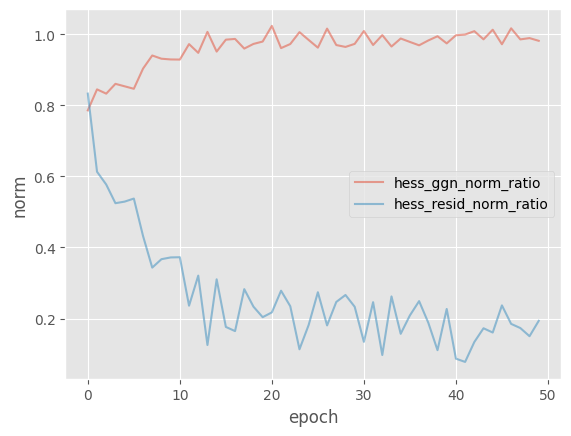

CPU times: user 15.7 s, sys: 122 ms, total: 15.9 s
Wall time: 15.3 s


In [15]:
%%time
def train():
    matrix_norms = {"hess_ggn_norm_ratio": [], "hess_resid_norm_ratio": []}
    model = FullyConnectedModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(50):
        hess = 0
        ggn = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            params = dict(model.named_parameters())
            hess += compute_hessian(model, params, data, target)
            ggn += compute_ggn(model, params, data, target)
        matrix_norms["hess_ggn_norm_ratio"].append(ggn.norm().sqrt().item() / hess.norm().sqrt().item())
        matrix_norms["hess_resid_norm_ratio"].append((hess - ggn).norm().sqrt().item() / hess.norm().sqrt().item())
    return matrix_norms

matrix_norms = train()

# plot
for k, v in matrix_norms.items():
    plt.plot(v, label=k, alpha=0.5)
plt.xlabel("epoch")
plt.ylabel("norm")
plt.legend()
plt.show()

# Fisher
- $F = \mathbb{E}_{p_{\theta}(x, y)}[\frac{\partial^2 \ell}{\partial \theta \theta^{\mathrm{T}}}]$
- $\neq H$ (In Fisher, samples are drawn from the model distribution)
- $\neq C$ (While C (uncentered covariance of gradient) is sometimes referred to as empirical Fisher, it is different)

Fisher possesses the following properties:
- When $\frac{\partial^2 \ell}{\partial f^2}$ does not depend on y, F coincides with GGN.
  - The loss function in this notebook satisfy this condition.

Now:
- Compute F as per its definition using samples drawn from the model distribution, and verify if it matches GGN.
- Compute using both first and second-order differentiation definitions.
- In a straightforward, Fisher could be approximated by repeatedly sampling from $p_{\theta}(y|x_k)$ for a specific x_k. However, since $p(y|x_k)$ is a categorical distribution in this case, we take expectations based on its probabilities.

In [16]:
# fisrt-order deriv definition
prob = model(data).softmax(dim=1)[0]
n_params = sum(p.numel() for p in model.parameters())
n_class = 3

fisher_grad = torch.zeros(n_params, n_params)
for target_tilde in range(n_class):
    g_tilde = compute_gradient(model, params, data, torch.tensor([target_tilde]))
    fisher_grad += (g_tilde @ g_tilde.T) * prob[target_tilde]

In [17]:
torch.allclose(fisher_grad, hess_ggn)

True

In [18]:
# second-order deriv definition
prob = model(data).softmax(dim=1)[0]
n_params = sum(p.numel() for p in model.parameters())
n_class = 3

fisher_hess = torch.zeros(n_params, n_params)
for target_tilde in range(n_class):
    hess_tilde = compute_hessian(model, params, data, torch.tensor([target_tilde]))
    fisher_hess += hess_tilde * prob[target_tilde]

In [19]:
torch.allclose(fisher_hess, hess_ggn)

True

In [20]:
torch.allclose(fisher_hess, fisher_grad)

True